# Reference:
https://www.kaggle.com/code/dansbecker/xgboost <br>
https://ithelp.ithome.com.tw/articles/10273094 <br>
https://stackoverflow.com/questions/51904422/how-can-i-use-r2-as-an-evaluation-metric-when-modeling

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import datetime
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, GridSearchCV, cross_val_score, RandomizedSearchCV
from xgboost import plot_importance
from sklearn import preprocessing

In [86]:
# origin dataset
# import dataset
df_train = pd.read_excel("Data_Train.xlsx", engine='openpyxl')
df_train
# print(df_train.dtypes)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [87]:
# Preprocessing

# drop null value
df_train.dropna(inplace=True)

# drop duplicates
df_train.drop_duplicates(keep='first', inplace=True)

# convert Dep_Time and Arrival_Time into hour and minute
# Dep_Time
df_train["Dep_hour"] = pd.to_datetime(df_train["Dep_Time"]).dt.hour
df_train["Dep_minute"] = pd.to_datetime(df_train["Dep_Time"]).dt.minute
df_train = df_train.drop(columns="Dep_Time")

# Arrival_Time
df_train["Arr_hour"] = pd.to_datetime(df_train["Arrival_Time"]).dt.hour
df_train["Arr_minute"] = pd.to_datetime(df_train["Arrival_Time"]).dt.minute
df_train = df_train.drop(columns="Arrival_Time")

# convert Date_of_Journey into timestamp
df_train["Date_of_Journey_Year"] = pd.to_datetime(
    df_train["Date_of_Journey"], format="%d/%m/%Y").dt.year
# ps. I don't think "year" is mandatory
df_train["Date_of_Journey_Month"] = pd.to_datetime(
    df_train["Date_of_Journey"], format="%d/%m/%Y").dt.month
df_train["Date_of_Journey_Day"] = pd.to_datetime(
    df_train["Date_of_Journey"], format="%d/%m/%Y").dt.day
df_train = df_train.drop(columns="Date_of_Journey")


# convert Duration into minute
df_train['Duration'] = df_train['Duration']\
    .str.replace("h", '*60')\
    .str.replace(' ', '+')\
    .str.replace('m', '*1')\
    .apply(eval)

# Encode categorical attributes

# Select categorical data
df_train_categorical = df_train[['Airline', 'Source', 'Destination']]
df_train.drop(["Airline","Source", "Destination"], axis=1, inplace=True)

# Use OneHotEncoder
df_train_categorical = pd.get_dummies(df_train_categorical, drop_first=True)

# Concat categorical and numerical data
train_preprocessed = pd.concat([df_train, df_train_categorical], axis=1)
train_target = df_train['Price']

# Drop 'Price' because price is the target variable
train_preprocessed.drop(['Price'], axis=1, inplace=True)

train_preprocessed

,Route,Duration,Total_Stops,Additional_Info,Dep_hour,Dep_minute,Arr_hour,Arr_minute,Date_of_Journey_Year,Date_of_Journey_Month,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,BLR → DEL,170,non-stop,No info,22,20,1,10,2019,3,...,0,0,0,0,0,0,0,0,0,1
1,CCU → IXR → BBI → BLR,445,2 stops,No info,5,50,13,15,2019,5,...,0,0,0,1,0,0,0,0,0,0
2,DEL → LKO → BOM → COK,1140,2 stops,No info,9,25,4,25,2019,6,...,0,0,1,0,0,1,0,0,0,0
3,CCU → NAG → BLR,325,1 stop,No info,18,5,23,30,2019,5,...,0,0,0,1,0,0,0,0,0,0
4,BLR → NAG → DEL,285,1 stop,No info,16,50,21,35,2019,3,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,CCU → BLR,150,non-stop,No info,19,55,22,25,2019,4,...,0,0,0,1,0,0,0,0,0,0
10679,CCU → BLR,155,non-stop,No info,20,45,23,20,2019,4,...,0,0,0,1,0,0,0,0,0,0
10680,BLR → DEL,180,non-stop,No info,8,20,11,20,2019,4,...,0,0,0,0,0,0,1,0,0,0
10681,BLR → DEL,160,non-stop,No info,11,30,14,10,2019,3,...,0,0,0,0,0,0,0,0,0,1


## Begin of Work

In [88]:
# score function
def cal_score(model):
    score = model.score(test_X, test_y)
    print('R-squared: ' + str(score*100) + '%')

    # MAE
    predictions = model.predict(test_X)
    print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

    # MSE
    predictions = model.predict(test_X)
    print("Mean Squared Error : " + str(mean_squared_error(predictions, test_y)))

    # RMSE
    predictions = model.predict(test_X)
    print("Root Mean Squared Error : " + str(mean_squared_error(predictions, test_y, squared=False)))

In [89]:
def CheckWeekend(year, month, day):
    convertDate = datetime.date(year, month, day)
    convertDateResult = convertDate.weekday()
    if convertDateResult <= 4:
        return True
    return False

In [90]:
# parameter range
n_estimators_range = list(np.arange(100,501,100))
leaning_rate_range = [0.01, 0.05, 0.1, 0.3]
max_depth_range = list(np.arange(5,20,1))

parameter_grid = {"n_estimators": n_estimators_range, 
                  "learning_rate": leaning_rate_range,
                  "max_depth": max_depth_range,}

In [154]:
## Train 1

train_data = copy.deepcopy(train_preprocessed)
train_data['Total_Stops'] = train_data['Total_Stops'].map({"non-stop":0, "1 stop": 1, "2 stops": 2, "3 stops":3, "4 stops": 4})
train_data.drop(["Route", "Additional_Info"], axis=1, inplace=True) # use later: Total_Stops
train_data["IsWeekend"] = train_data.apply(lambda x: 1 if CheckWeekend(x["Date_of_Journey_Year"], x["Date_of_Journey_Month"], x["Date_of_Journey_Day"]) else 0, axis=1)

In [129]:
# select_feat = [13, 12, 0, 14, 28, 1, 8, 23, 7, 16, 11, 21, 10, 9, 22, 4, 18, 15, 3, 5]
# train_data = train_data.iloc[:,select_feat]
# train_data

In [155]:
# create the normaliser
scaler = preprocessing.StandardScaler()
train_data[['Duration']] = scaler.fit_transform(train_data[['Duration']])

In [151]:
train_X, test_X, train_y, test_y = train_test_split(train_data, train_target, test_size=0.3, random_state=42)

In [142]:
xgboost_model = XGBRegressor()

estimator_gs = RandomizedSearchCV(xgboost_model, parameter_grid, scoring="neg_mean_squared_error", cv=15) #RandomizedSearchCV
estimator_gs.fit(train_X, train_y)
estimator_gs.best_params_

{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.05}

In [158]:
#train model based on the best parameter
print("---Model 1 (best)---")
xgboost_model_best = XGBRegressor(n_estimators = 200, learning_rate = 0.05, max_depth=8, n_jobs=-1)
xgboost_model_best.fit(train_X, train_y, early_stopping_rounds=5,eval_set=[(test_X, test_y)], verbose=False)
cal_score(xgboost_model_best)
print("---Model 2 (Basic) ---")

# cross_xgboost = cross_val_score(xgboost_rs, data_train, target_train, cv=5, scoring='r2')
# print('Average Cross-Validation R-squared score: ', cross_xgboost.mean())

xgboost_model = XGBRegressor()
xgboost_model.fit(train_X, train_y, early_stopping_rounds=5,eval_set=[(test_X, test_y)], verbose=False)
cal_score(xgboost_model)

---Model 1 (best)---
R-squared: 83.69097964919774%
Mean Absolute Error : 1226.3096540778563
Mean Squared Error : 3387153.552224878
Root Mean Squared Error : 1840.422112512474
---Model 2 (Basic) ---
R-squared: 83.84626507199422%
Mean Absolute Error : 1187.0978101698142
Mean Squared Error : 3354902.9596006596
Root Mean Squared Error : 1831.639418553952


[0.07123928 0.03882704 0.00647822 0.00654295 0.01261309 0.00586622
 0.         0.02172579 0.02690934 0.01206308 0.01599749 0.03657388
 0.12639405 0.41618183 0.03496287 0.00539411 0.02366863 0.
 0.0117451  0.00060587 0.00268364 0.0186497  0.00807717 0.02377908
 0.         0.01158259 0.         0.         0.05451477 0.0069242 ]


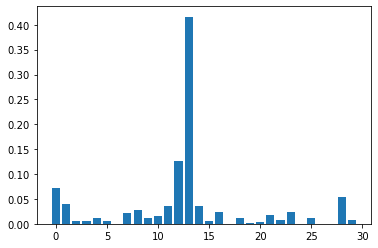

In [133]:
# feature importance
print(xgboost_model.feature_importances_)
# plot
plt.bar(range(len(xgboost_model.feature_importances_)), xgboost_model.feature_importances_)
plt.show()

[0.11460014 0.05171803 0.00500615 0.00696301 0.01073352 0.00659458
 0.         0.02363054 0.03411411 0.01414551 0.01423317 0.01860912
 0.11988416 0.2929592  0.08481863 0.00801302 0.01966958 0.
 0.0102116  0.00077542 0.00622186 0.01737634 0.01263481 0.03330444
 0.         0.0051745  0.         0.         0.08476907 0.00383952]


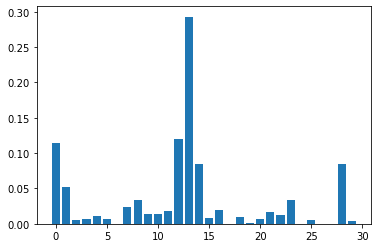

In [134]:
# feature importance
print(xgboost_model_best.feature_importances_)
# plot
plt.bar(range(len(xgboost_model_best.feature_importances_)), xgboost_model_best.feature_importances_)
plt.show()

In [135]:
feat_inportant = xgboost_model_best.feature_importances_
feat_inportant = sorted(range(len(feat_inportant)), key=lambda k: feat_inportant[k], reverse=True)
feat_inportant[:25]

[13,
 12,
 0,
 14,
 28,
 1,
 8,
 23,
 7,
 16,
 11,
 21,
 10,
 9,
 22,
 4,
 18,
 15,
 3,
 5,
 20,
 25,
 2,
 29,
 19]

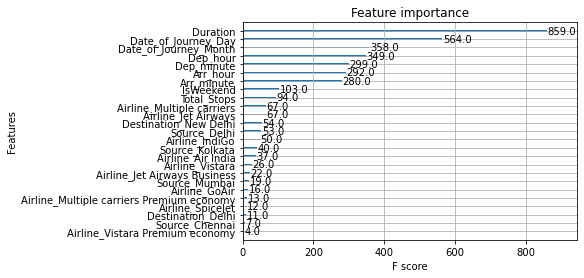

In [136]:
# plot feature importance
plot_importance(xgboost_model)
plt.show()

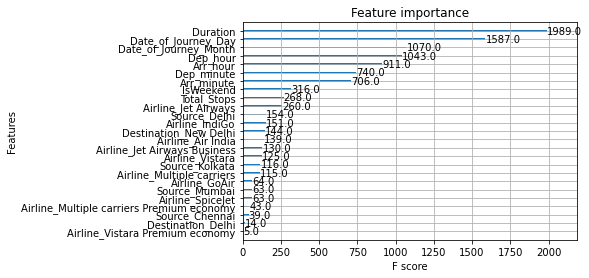

In [137]:
# plot feature importance
plot_importance(xgboost_model_best)
plt.show()

# Performace comparison
## Based Model
r2 = 83.53 , MAE = 1233.22

## Tuning Model
max_depth = 8, n_estimators = 500, learning_rate = 0.05 => r2 = 84.84 , MAE = 1185.10 (random state = 123) <br>

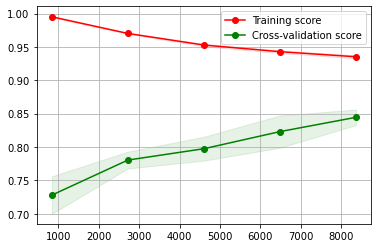

In [44]:
# learning Curve
train_sizes, train_scores, test_scores = learning_curve(xgboost_model, train_data, train_target, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.draw()
plt.show()

# Training with different dataset

In [73]:
def CheckWeekend(year, month, day):
    convertDate = datetime.date(year, month, day)
    convertDateResult = convertDate.weekday()
    if convertDateResult <= 4:
        return False
    return True

# Preprocessing
# import dataset
df = pd.read_excel("Data_Train.xlsx", engine='openpyxl')

# drop null value
df.dropna(inplace=True)

# drop duplicates
df.drop_duplicates(keep='first', inplace=True)

# convert Dep_Time and Arrival_Time into hour and minute
# Dep_Time
df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
df["Dep_minute"] = pd.to_datetime(df["Dep_Time"]).dt.minute
df = df.drop(columns="Dep_Time")

# Arrival_Time
df["Arr_hour"] = pd.to_datetime(df["Arrival_Time"]).dt.hour
df["Arr_minute"] = pd.to_datetime(df["Arrival_Time"]).dt.minute
df = df.drop(columns="Arrival_Time")

# convert Date_of_Journey into timestamp
df["Date_of_Journey_Year"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.year
# ps. I don't think "year" is mandatory
df["Date_of_Journey_Month"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.month
df["Date_of_Journey_Day"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.day
df = df.drop(columns="Date_of_Journey")


# convert Duration into minute
df['Duration'] = df['Duration']\
    .str.replace("h", '*60')\
    .str.replace(' ', '+')\
    .str.replace('m', '*1')\
    .apply(eval)

# drop Additional_Info 
df.drop(['Additional_Info'], axis=1, inplace=True)

# drop Route
df.drop(['Route'], axis=1, inplace=True) 

# Encode categorical attributes
# Select categorical data
df_categorical = df[['Airline', 'Source', 'Destination']]
df.drop(['Airline', 'Source', 'Destination'], axis=1, inplace=True)


# Encode
df_categorical = pd.get_dummies(df_categorical, drop_first=True)
df['Total_Stops'] = df['Total_Stops'].map({"non-stop":0, "1 stop": 1, "2 stops": 2, "3 stops":3, "4 stops": 4})

# Concat categorical and numerical data
preprocessed = pd.concat([df, df_categorical], axis=1)
target = df['Price']

# Drop 'Price' because price is the target variable
preprocessed.drop(['Price'], axis=1, inplace=True)

# # Train_Test_Split
# data_train, data_test, target_train, target_test = train_test_split(
#     preprocessed, target,test_size=0.3, random_state=42)

## Feature Engineering - check if date is weekday or weekend
preprocessed["IsWeekend"] = preprocessed.apply(lambda x: 1 if CheckWeekend(x["Date_of_Journey_Year"], x["Date_of_Journey_Month"], x["Date_of_Journey_Day"]) else 0, axis=1)

preprocessed

,Duration,Total_Stops,Dep_hour,Dep_minute,Arr_hour,Arr_minute,Date_of_Journey_Year,Date_of_Journey_Month,Date_of_Journey_Day,Airline_Air India,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,IsWeekend
0,170,0,22,20,1,10,2019,3,24,0,...,0,0,0,0,0,0,0,0,1,1
1,445,2,5,50,13,15,2019,5,1,1,...,0,0,1,0,0,0,0,0,0,0
2,1140,2,9,25,4,25,2019,6,9,0,...,0,1,0,0,1,0,0,0,0,1
3,325,1,18,5,23,30,2019,5,12,0,...,0,0,1,0,0,0,0,0,0,1
4,285,1,16,50,21,35,2019,3,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,150,0,19,55,22,25,2019,4,9,0,...,0,0,1,0,0,0,0,0,0,0
10679,155,0,20,45,23,20,2019,4,27,1,...,0,0,1,0,0,0,0,0,0,1
10680,180,0,8,20,11,20,2019,4,27,0,...,0,0,0,0,0,1,0,0,0,1
10681,160,0,11,30,14,10,2019,3,1,0,...,0,0,0,0,0,0,0,0,1,0


In [57]:
target

0         3897
1         7662
2        13882
3         6218
4        13302
         ...  
10678     4107
10679     4145
10680     7229
10681    12648
10682    11753
Name: Price, Length: 10462, dtype: int64

In [80]:
# import dataset
df = pd.read_excel("Test_set.xlsx", engine='openpyxl')

# drop null value
df.dropna(inplace=True)

# drop duplicates
# df.drop_duplicates(keep='first', inplace=True)

# convert Dep_Time and Arrival_Time into hour and minute
# Dep_Time
df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
df["Dep_minute"] = pd.to_datetime(df["Dep_Time"]).dt.minute
df = df.drop(columns="Dep_Time")

# Arrival_Time
df["Arr_hour"] = pd.to_datetime(df["Arrival_Time"]).dt.hour
df["Arr_minute"] = pd.to_datetime(df["Arrival_Time"]).dt.minute
df = df.drop(columns="Arrival_Time")

# convert Date_of_Journey into timestamp
df["Date_of_Journey_Year"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.year
# ps. I don't think "year" is mandatory
df["Date_of_Journey_Month"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.month
df["Date_of_Journey_Day"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.day
df = df.drop(columns="Date_of_Journey")


# convert Duration into minute
df['Duration'] = df['Duration']\
    .str.replace("h", '*60')\
    .str.replace(' ', '+')\
    .str.replace('m', '*1')\
    .apply(eval)

# drop Additional_Info 
df.drop(['Additional_Info'], axis=1, inplace=True)

# drop Route
df.drop(['Route'], axis=1, inplace=True) 

# Encode categorical attributes
# Select categorical data
df_categorical = df[['Airline', 'Source', 'Destination']]
df.drop(['Airline', 'Source', 'Destination'], axis=1, inplace=True)


# Encode
df_categorical = pd.get_dummies(df_categorical, drop_first=True)
df['Total_Stops'] = df['Total_Stops'].map({"non-stop":0, "1 stop": 1, "2 stops": 2, "3 stops":3, "4 stops": 4})

# Concat categorical and numerical data
Test_x = pd.concat([df, df_categorical], axis=1)

## Feature Engineering - check if date is weekday or weekend
Test_x["IsWeekend"] = Test_x.apply(lambda x: 1 if CheckWeekend(x["Date_of_Journey_Year"], x["Date_of_Journey_Month"], x["Date_of_Journey_Day"]) else 0, axis=1)

Test_x.insert(17, "Airline_Trujet", 0)

Test_x

,Duration,Total_Stops,Dep_hour,Dep_minute,Arr_hour,Arr_minute,Date_of_Journey_Year,Date_of_Journey_Month,Date_of_Journey_Day,Airline_Air India,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,IsWeekend
0,655,1,17,30,4,25,2019,6,6,0,...,0,1,0,0,1,0,0,0,0,0
1,240,1,6,20,10,20,2019,5,12,0,...,0,0,1,0,0,0,0,0,0,1
2,1425,1,19,15,19,0,2019,5,21,0,...,0,1,0,0,1,0,0,0,0,0
3,780,1,8,0,21,0,2019,5,21,0,...,0,1,0,0,1,0,0,0,0,0
4,170,0,23,55,2,45,2019,6,24,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,1435,1,20,30,20,25,2019,6,6,1,...,0,0,1,0,0,0,0,0,0,0
2667,155,0,14,20,16,55,2019,3,27,0,...,0,0,1,0,0,0,0,0,0,0
2668,395,1,21,50,4,25,2019,3,6,0,...,0,1,0,0,1,0,0,0,0,0
2669,915,1,4,0,19,15,2019,3,6,1,...,0,1,0,0,1,0,0,0,0,0


In [66]:
Test_y = pd.read_excel("Sample_submission.xlsx", engine='openpyxl')
Test_y

,Price
0,15998
1,16612
2,25572
3,25778
4,16934
...,...
2666,14046
2667,14086
2668,22720
2669,23544


In [81]:
from sklearn.linear_model import LinearRegression
xgboost_model = XGBRegressor() #LinearRegression
xgboost_model.fit(preprocessed, target)
score = xgboost_model.score(Test_x, Test_y)
print('R-squared: ' + str(score*100) + '%')

# MAE
predictions = xgboost_model.predict(Test_x)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, Test_y)))

# MSE
predictions = xgboost_model.predict(Test_x)
print("Mean Squared Error : " + str(mean_squared_error(predictions, Test_y)))

# RMSE
predictions = xgboost_model.predict(Test_x)
print("Root Mean Squared Error : " + str(mean_squared_error(predictions, Test_y, squared=False)))

R-squared: -557.7119807481197%
Mean Absolute Error : 11269.653440189111
Mean Squared Error : 164721606.95867607
Root Mean Squared Error : 12834.391569477537
